
--- Resumen de Grupos ---
Conservador: 2 activos
  → JNJ, PEP
Moderado: 3 activos
  → MSFT, AMD, UNH
Arriesgado: 3 activos
  → MCD, DOCU, TSLA
Muy Arriesgado: 12 activos
  → PG, KO, WMT, AAPL, HD, META, NVDA, NFLX, V, GOOGL, BRKb, JPM



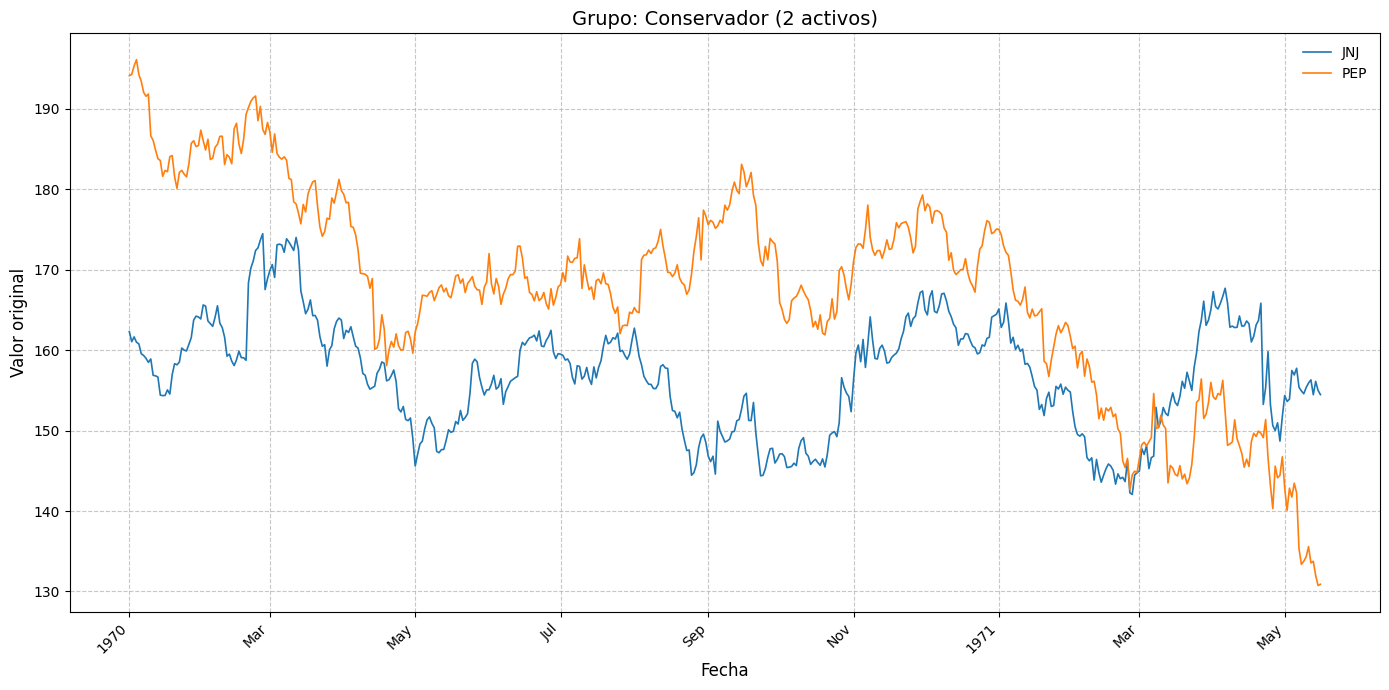

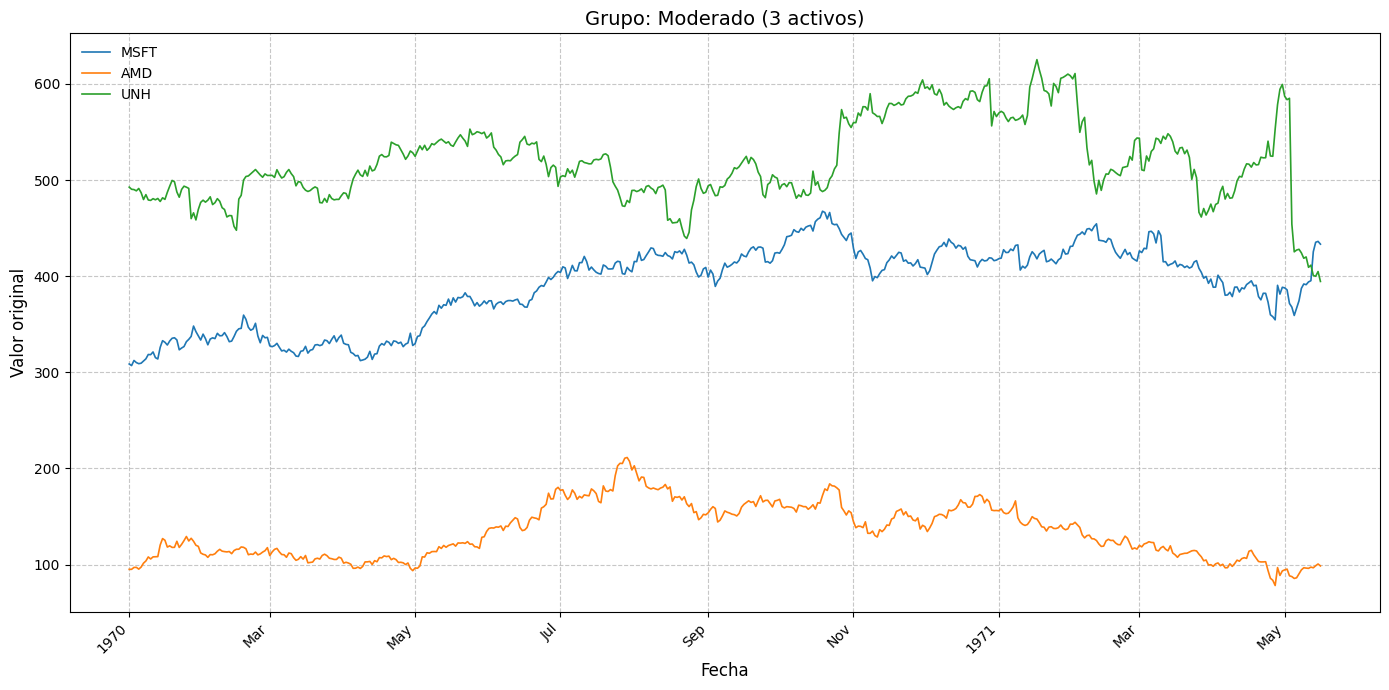

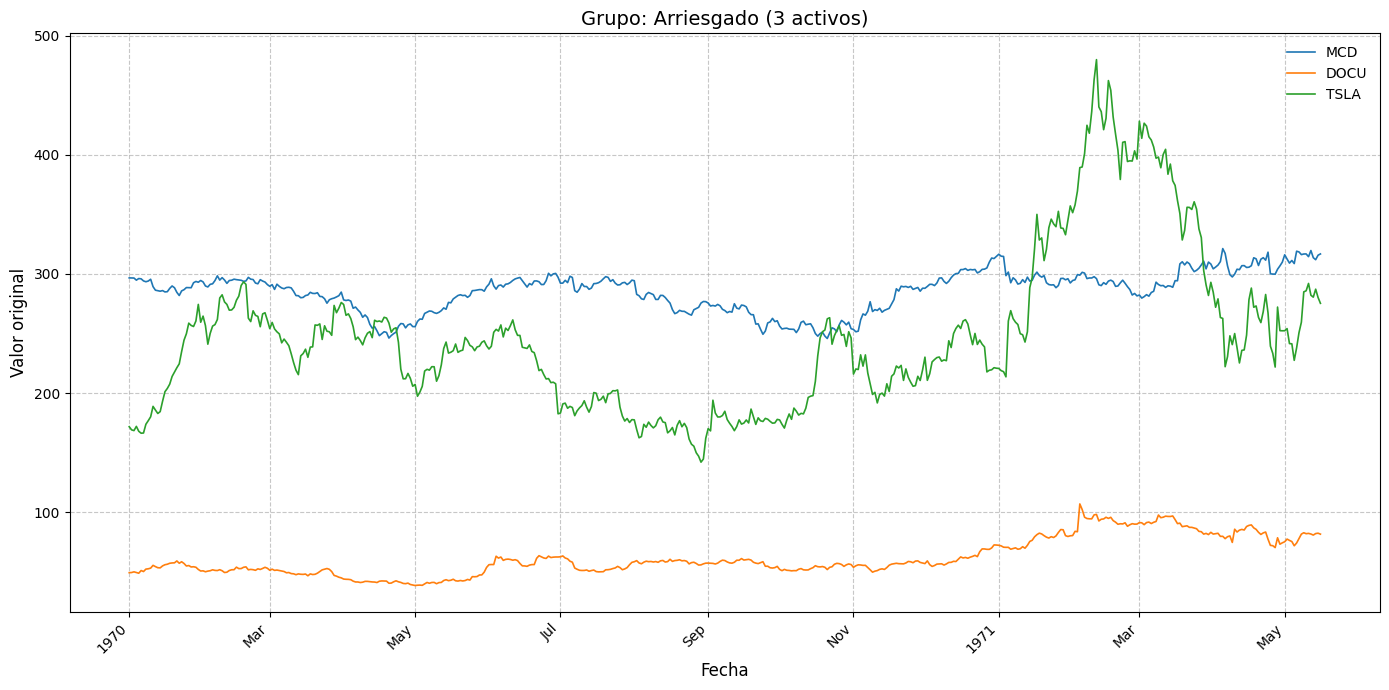

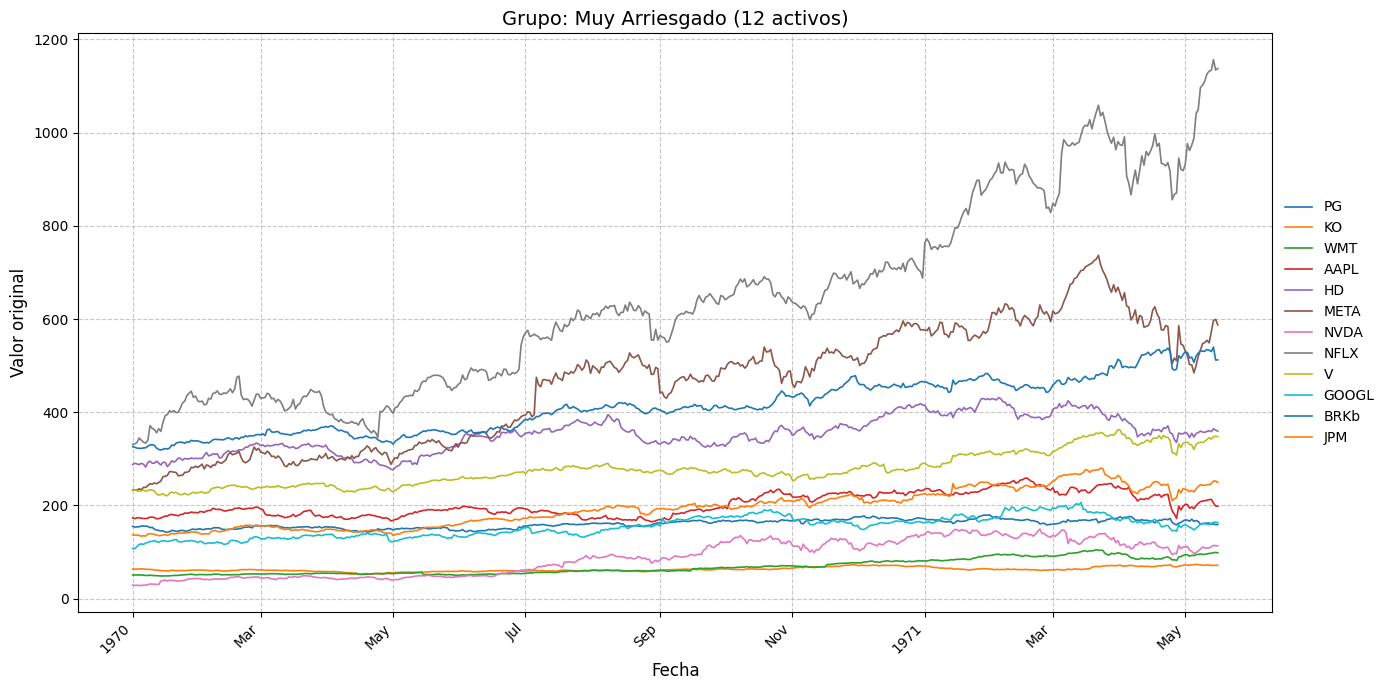

Proceso completado. Revisa "Resultados_Grupos.xlsx".


In [83]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 1) Load data from CSV with proper date parsing
df = pd.read_csv('DATA.csv', parse_dates=['Date'], index_col='Date')
tickers = df.columns.to_list()

# 2) Original data matrix
raw_data = df.values  # shape: (n_observations, n_assets)

# 3) Normalize data using StandardScaler for better clustering
scaler = StandardScaler()
normalized_data = scaler.fit_transform(raw_data)
X = normalized_data.T  # transpose: each asset is a sample with time-series features

# 4) Determine optimal number of clusters (can be adjusted)
n_clusters = 4

# 5) Implement balanced KMeans clustering
# We'll use regular KMeans but with a verification step to ensure balance
max_imbalance = 0.5  # Maximum allowed imbalance ratio (smallest:largest cluster)
best_balance = 0
best_labels = None
best_kmeans = None

# Try multiple initializations to find balanced clusters
for attempt in range(15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42+attempt, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Count assets in each cluster
    unique, counts = np.unique(labels, return_counts=True)
    
    # Calculate balance ratio (smallest:largest)
    min_count = np.min(counts)
    max_count = np.max(counts)
    balance_ratio = min_count / max_count
    
    # Save the most balanced clustering
    if balance_ratio > best_balance:
        best_balance = balance_ratio
        best_labels = labels.copy()
        best_kmeans = kmeans
    
    # If we have a good enough balance, stop
    if balance_ratio >= max_imbalance:
        print(f"Found well-balanced clusters on attempt {attempt+1} with ratio {balance_ratio:.2f}")
        break

# Use the best clustering found
labels = best_labels
kmeans = best_kmeans

# 6) Descriptive cluster labels (sorted by mean volatility for meaningful labeling)
# Calculate volatility for each asset
volatilities = np.std(normalized_data, axis=0)
cluster_volatility = [np.mean(volatilities[labels == i]) for i in range(n_clusters)]

# Sort clusters by volatility to assign meaningful labels
volatility_order = np.argsort(cluster_volatility)
group_labels = ['Conservador', 'Moderado', 'Arriesgado', 'Muy Arriesgado']

# Create a mapping from original cluster numbers to sorted labels
label_mapping = {vol_idx: i for i, vol_idx in enumerate(volatility_order)}
sorted_labels = np.array([label_mapping[label] for label in labels])

# 7) Console summary with balanced clusters
print('\n--- Resumen de Grupos ---')
for k in range(n_clusters):
    idx = np.where(sorted_labels == k)[0]
    print(f'{group_labels[k]}: {len(idx)} activos')
    if len(idx) > 0:
        activos = ', '.join([tickers[i] for i in idx])
        print(f'  → {activos}')
print()

# 8) Plot each cluster using original values with proper date formatting
for k in range(n_clusters):
    idx = np.where(sorted_labels == k)[0]
    if len(idx) == 0:
        continue

    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Get the date range from the DataFrame index
    dates = df.index
    
    for i in idx:
        ax.plot(dates, raw_data[:, i], linewidth=1.2, label=tickers[i])

    # Format dates on X-axis
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set title and labels
    ax.set_title(f'Grupo: {group_labels[k]} ({len(idx)} activos)', fontsize=14)
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Valor original', fontsize=12)
    
    # Optimize legend placement
    if len(idx) > 10:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    else:
        ax.legend(loc='best', frameon=False)
        
    plt.tight_layout()
    plt.show()

# 9) Export results to Excel, one sheet per group
output_file = 'Resultados_Grupos.xlsx'
if os.path.exists(output_file):
    os.remove(output_file)

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # First write a summary sheet
    summary_data = []
    for k in range(n_clusters):
        idx = np.where(sorted_labels == k)[0]
        assets_list = [tickers[i] for i in idx]
        summary_data.append({
            'Grupo': group_labels[k],
            'Número de Activos': len(idx),
            'Activos': ', '.join(assets_list)
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Resumen', index=False)
    
    # Then write individual sheets for each group
    for k in range(n_clusters):
        sheet_name = group_labels[k]
        idx = np.where(sorted_labels == k)[0]
        if len(idx) == 0:
            # Empty sheet (just header)
            pd.DataFrame().to_excel(writer, sheet_name=sheet_name, index=False)
        else:
            sub_df = pd.DataFrame(
                raw_data[:, idx],
                index=df.index,
                columns=[tickers[i] for i in idx]
            )
            sub_df.to_excel(writer, sheet_name=sheet_name)

print(f'Proceso completado. Revisa "{output_file}".')